<a href="https://colab.research.google.com/github/lwehausen/Simulation/blob/main/Insurance_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#To run R in Google Colab:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("cubature", repos =  "http://cran.us.r-project.org")
library(cubature)

In [ ]:
%%R
install.packages("pracma", repos =  "http://cran.us.r-project.org")
library(pracma)

In [ ]:
%%R
library(dplyr)

This is a simplified version of two common problems faced by insurance companies: calculating the probability that they go bust and estimating how much money they will make. Suppose that an insurance company has current assets of $\$1,000,000$. They have $n = 1,000$ customers who each pay an annual premium of $\$5,500$, paid at the start of each year. Based on previous experience, it is estimated that the probability of a customer making a claim is $p = 0.1$ per year, independently
of previous claims and other customers. The size $X$ of a claim varies, and is
believed to have the following density, with $\alpha = 3$ and $\beta = 100,000$, \\
$f(x) = \begin{cases}
    \frac{\alpha\beta^{\alpha}}{(x + \beta)^{\alpha + 1}},& \text{for} \: x\geq 0 \\
    0, & \text{for} \: x < 0.
\end{cases}$ \\
(Such an $X$ is said to have a Pareto distribution, and in the real world is not
an uncommon model for the size of an insurance claim.) \\
We consider the fortunes of the insurance company over a five-year period.
Let $Z(t)$ be the company’s assets at the end of year $t$, so \\
$Z(0) = 1,000,000,$ \\

$Z(t) = \begin{cases} \max\{Z(t-1) + \text{premiums} - \text{claims}, 0\} \: \text{if} \: Z(t-1) > 0, \\
0 \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;\text{if} \: Z(t-1) = 0.
\end{cases}$ \\
Note that if $Z(t)$ falls below $0$ then it stays there. That is, if the company goes bust then it stops trading.

Let $X$ be the size of a typical claim as above. Calculate the cdf $F_X$, $\mathbb{E}X$, and $\text{Var} X$.

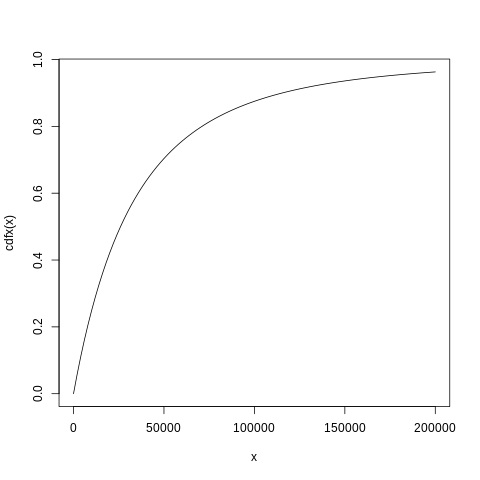

In [5]:
%%R
#calculate cdf Fx. Plotting the integral of Fx.
cdfx <- function(x) {
  1-(100000/(x+100000))^3
}
curve(cdfx,xlim=c(0,200000))

In [6]:
%%R
#calculate expected values; remember, x is never less than 0.
Ex <- as.numeric(cubintegrate(function(x) x*3*100000^3/(x+100000)^4, 0,Inf))
Ex1 <- Ex[1]
Ex1

[1] 50000


In [7]:
%%R
#calculate variance
#E[x^2] - E[x]^2
Ex_2 <- as.numeric(cubintegrate(function(x) x^2*3*100000^3/(x+100000)^4, 0,Inf))
Ex2 <- Ex_2[1]
#variance
var <- Ex2 - Ex1^2
var

[1] 7.5e+09


Using the inversion method, write a subroutine to simulate $X$.

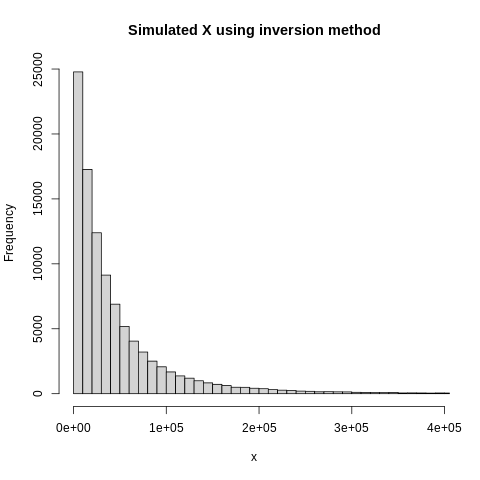

In [8]:
%%R
#simulated pdf
u <- runif(100000)
Finv <- function(u,beta = 100000) {(-beta/nthroot((u-1),3)) -beta}
y <- Finv(u)

hist(y,breaks = seq(0,10000000,10000), xlim = c(0,390000), xlab = "x", ylab = "Frequency", main = "Simulated X using inversion method")

Use simulation to estimate the pdf of X and compare your estimate to the true pdf. Include a plot.

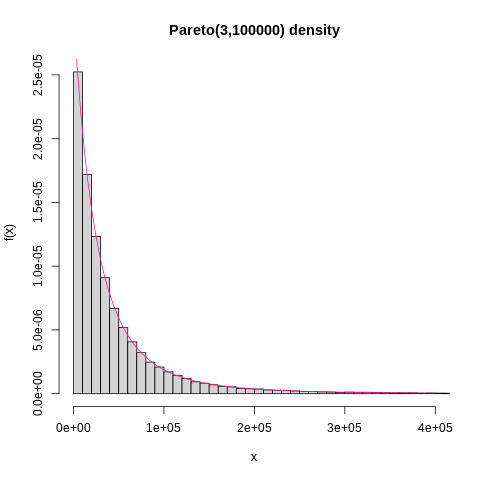

In [10]:
%%R
#simulated pdf
u <- runif(100000)
Finv <- function(u,beta = 100000) {(-beta/nthroot((u-1),3)) -beta}
y <- Finv(u)

hist(y, breaks = seq(0,10000000,10000), xlim = c(0,400000), xlab = "x", ylab = "f(x)", main = "Pareto(3,100000) density", freq = FALSE)

pdf <- function(x) {
  (3*100000^3)/(x+100000)^4
}
curve(pdf, col = "deeppink", add = TRUE)

Simulated and true pdf for insurance risk.

Write a function to simulate the assets of the company over five years, then use it to plot the assets as a graph.

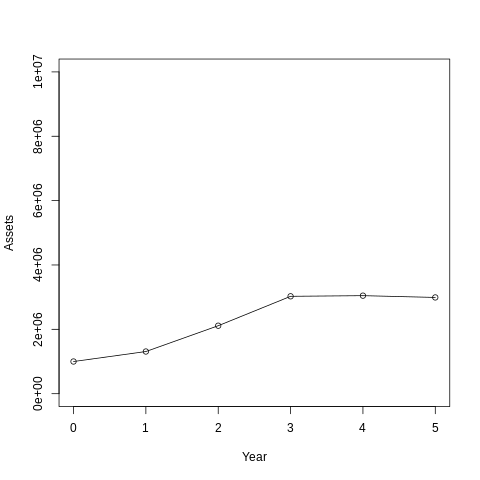

In [11]:
%%R
simmy <- function(n) {
  un <- runif(n)
  y <- Finv(un)
}

sim2 <- function(n) {
  if (n == 0) {
    return(c(1000000))
  } else {
    current <- sim2(n-1)
    nclaims <- as.numeric(rbinom(1,1000,0.1))
    new <- current[n] + 5500000 - sum(simmy(nclaims))
    if (new > 0 && current[n] !=0) {
      output <- append(current, new)
    } else {
      output <- append(current, 0)
    }
    return(output)
  }
}

plot(0:5, sim2(5), ylim = c(0, 10000000), type = "o", xlab = "Year", ylab = "Assets")

Using your function, estimate:
1. The probability that the company goes bust, and
2. The expected assets at the end five years.

In [13]:
%%R
five <- data.frame(output = numeric())

for (i in 1:10000) {
  sim_output <- sim2(5)
  outval <- sim_output[6]
  row <- data.frame(output = outval)
  five <- rbind(five, row)
}

probbankrupt <- sum(five == 0)/NROW(five)
probbankrupt

[1] 0.1675


In [14]:
%%R
#expected assets after 5 years
exp_assets <- colMeans(five)
exp_assets

 output 
3383389 


Suppose now that the company takes profits at the end of each year. That is, if $Z(t) > 1,000,000$ then $Z(t)− 1,000,000$ is paid out to the shareholders. If $Z(t) ≤ 1,000,000$ then the shareholders get nothing that year.

Using this new scheme, estimate
1. The probability of going bust.
2. The expected assets at the end of five years, and
3. The expected total profits taken over the five years.

In [15]:
%%R
sim3 <- function(n) {
  if (n==0) {
    return(c(1000000, 0))
  } else {
    current <- sim3(n-1)
    nclaims <- as.numeric(rbinom(1,1000,0.1))
    new <- current[n] + 5500000 - sum(simmy(nclaims))

    if (new>1000000 && current[n] != 0) {
      profit <- new - 1000000
      new <- 1000000
    } else {
      profit <- 0
    }
    output <- append(current, new)
    output[2] <- current[2] + profit
    return(output)
  }
}

In [17]:
%%R
#probability of going bust
nsims <- 10000
bust <- 0

for (i in 1:nsims) {
  sim_output <- sim3(5)
  if (any(sim_output < 0)) {
    bust <- bust + 1
  }
}

probbankrupt3 <- bust/nsims
probbankrupt3

[1] 0.3666


In [18]:
%%R
#expected assets after five years
nsims2 <- 10000
totalassets <- 0

for (i in 1:nsims2) {
  sim_output2 <- sim3(5)
  totalassets <- totalassets + sim_output2[6]
}

expected_assets <- totalassets/nsims2
expected_assets

[1] 620057.1


In [19]:
%%R
#expected total profits after five years
nsims3 <- 10000
totalprofits <- 0

for (i in 1:nsims3) {
  sim_output3 <- sim3(5)
  totalprofits <- totalprofits + sim_output3[2]
}

expected_profits <- totalprofits/nsims3
expected_profits

[1] 2911195


The company has a higher chance, more than double, of going bust. The expected profits are nearly the same amount as the previous expected assets. The now expected assets are significantly less than before but this is not surprising since money is now split between assets and profits.